In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, shape, Point
import pyproj
from functools import partial
from shapely.ops import transform
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn import neural_network
from scipy.stats import uniform 
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import feature_selection

%matplotlib inline

In [64]:
#tabela de volumes por par de equipamentos
od_vol = pd.read_csv('cost_paths_cars.csv').drop(columns = ['Unnamed: 0', 'row_id']).rename(columns = {'cat1':'vol'})
od_vol = od_vol.dropna(how = 'all')

#tabela de localização de cada equipamento
equips_map = gpd.read_file('../pacote_USP/equips.shp')

#tabela com geometria de zonas de são paulo
sp_zones = gpd.read_file('../Shape/Zonas_2017_region.shp')
sp_zones = sp_zones[sp_zones.NomeMunici == 'São Paulo']
sp_zones.crs = {'init': 'epsg:22523'}
sp_zones = sp_zones.to_crs({'init': 'epsg:4326'})
                    
#tabela com a zona de cada equipamento                                      
equips_within_zones = gpd.sjoin(equips_map, sp_zones, how="inner", op='intersects')
equips_within_zones = equips_within_zones[['id','geometry','NumeroZona']]
                    
#tabela com os volumes para cada par de equipamento com a zona do equipamento de destino                    
vol_within_zones = pd.merge(od_vol,equips_within_zones, how = 'inner', left_on = 'last', \
                         right_on = 'id', right_index = False, left_index = False)
vol_within_zones = vol_within_zones.rename(columns = { 'first':'fid', \
                                                'last':'lid','cat1':'vol', \
                                                'NumeroZona':'lzone'})

vol_within_zones = pd.merge(vol_within_zones,equips_within_zones[['id','NumeroZona']], how = 'inner', left_on = 'fid', \
                         right_on = 'id', right_index = False, left_index = False)
vol_within_zones = vol_within_zones.rename(columns = {'NumeroZona':'fzone'})[['fid','lid','vol','fzone','lzone','cost_f']]


                    
#tabela da pesquisa od                    
od_survey = pd.read_csv('../pesquisa_OD.csv', sep =';').dropna(how = 'all').replace('-',0)


vol_within_zones_data = pd.merge(vol_within_zones,od_survey, how = 'inner', left_on = 'lzone', \
                         right_on = 'zona', right_index = False, left_index = False
                        )
vol_within_zones_data = pd.merge(vol_within_zones_data,od_survey[['zona']], how = 'inner', left_on = 'fzone', \
                         right_on = 'zona', right_index = False, left_index = False
                        )


In [65]:
equips_map.head()
cost_min = pd.read_csv('../OCR/cost_min.csv')
cost_min['from-to'] = cost_min['fid'].map(str) +'-'+cost_min['tid'].map(str)
cost_min = cost_min.drop(columns= ['fid'])
cost_min.head(1)

,tid,cost,pass_avi,sent,cost_f,from-to
0,31022,1.718334,no,1,1.72,31021-31022


In [66]:
od_matrix0 = vol_within_zones_data[['fid','lid','vol']].pivot(index='fid', columns='lid', values='vol')
od_matrix0.to_excel("OD_antes.xlsx", engine='xlsxwriter')
res = od_matrix0.unstack().reset_index(name='vol')
od_vol_missing = res[res.vol.isnull()]
od_vol_missing['first-last'] = od_vol_missing['fid'].map(str) +'-'+od_vol_missing['lid'].map(str)
od_vol_missing = pd.merge(od_vol_missing,cost_min,how = 'inner', left_on = 'first-last', right_on = 'from-to' )
od_vol_missing = od_vol_missing[['fid','lid','cost_f','vol']]


od_vol_missing = pd.merge(od_vol_missing,equips_within_zones, how = 'inner', left_on = 'lid', \
                         right_on = 'id', right_index = False, left_index = False)
od_vol_missing = od_vol_missing.rename(columns = {'NumeroZona':'lzone'})


od_vol_missing = pd.merge(od_vol_missing,equips_within_zones[['id','NumeroZona']], how = 'inner', left_on = 'fid', \
                         right_on = 'id', right_index = False, left_index = False)


od_vol_missing = od_vol_missing.rename(columns = {'NumeroZona':'fzone'})[['fid','lid','vol','fzone','lzone','cost_f']]

od_vol_missing = pd.merge(od_vol_missing,od_survey, how = 'inner', left_on = 'lzone', \
                         right_on = 'zona', right_index = False, left_index = False)

od_vol_missing = pd.merge(od_vol_missing,od_survey[['zona']], how = 'inner', left_on = 'fzone', \
                         right_on = 'zona', right_index = False, left_index = False)

od_vol_missing = od_vol_missing.drop(columns = ['lzone','fzone','zona_x','zona_y','nome','municipio'])

od_vol_missing.head()


C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,fid,lid,vol,cost_f,domicilios,familias,populacao,matriculas,empregos,automoveis,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
0,10171,10000,NaN,0.93,5140.0,5140.0,13293.0,9056.5,23051.8,5271.1,...,829.2,2403.6,34686.8,12224.5,1941.8,6065.4,3697.4,341.5,3384.4,1406.0
1,12067,10000,NaN,0.95,5140.0,5140.0,13293.0,9056.5,23051.8,5271.1,...,829.2,2403.6,34686.8,12224.5,1941.8,6065.4,3697.4,341.5,3384.4,1406.0
2,10171,10021,NaN,1.11,44813.0,44992.7,138839.0,22532.1,21666.4,19501.6,...,11363.0,12907.9,47332.3,94740.9,13484.0,3637.0,12553.1,726.1,12118.6,961.3
3,10171,12201,NaN,1.09,44813.0,44992.7,138839.0,22532.1,21666.4,19501.6,...,11363.0,12907.9,47332.3,94740.9,13484.0,3637.0,12553.1,726.1,12118.6,961.3
4,10171,13672,NaN,1.12,44813.0,44992.7,138839.0,22532.1,21666.4,19501.6,...,11363.0,12907.9,47332.3,94740.9,13484.0,3637.0,12553.1,726.1,12118.6,961.3


In [5]:
len(res[res.vol.isnull()]['lid'].unique())

375

In [6]:
od_vol_missing.shape[0]

28045

In [9]:
#planilha de pares com volumes presentes
od_vol_filled = vol_within_zones_data.drop(columns = ['lzone','fzone','zona_x','zona_y','nome','municipio'])
od_vol_filled.head()

,fid,lid,vol,cost_f,domicilios,familias,populacao,matriculas,empregos,automoveis,...,atr_motivo_trabalho_industria,atr_motivo_trabalho_comercio,atr_motivo_trabalho_servcos,atr_motivo_educacao,atr_motivo_compras,atr_motivo_saude,atr_motivo_lazer,atr_motivo_procurar_emprego,atr_motivo_assuntos_pessoais,atr_motivo_refeicao
0,10000,10006,6.500,0.34,7996.0,7996.0,18401.0,4010.2,12141.9,2582.2,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
1,10146,10006,4.667,0.32,7996.0,7996.0,18401.0,4010.2,12141.9,2582.2,...,1956.8,1345.7,19550.9,11491.3,1789.2,656.5,1842.3,0.0,1305.0,891.8
2,10000,10165,4.200,0.28,6836.0,6836.0,14277.0,1979.1,12564.2,7612.0,...,1391.3,5000.3,18861.1,6241.9,3973.8,2079.7,2159.0,0.0,1728.9,1108.9
3,10000,11172,5.467,0.30,6836.0,6836.0,14277.0,1979.1,12564.2,7612.0,...,1391.3,5000.3,18861.1,6241.9,3973.8,2079.7,2159.0,0.0,1728.9,1108.9
4,10146,10165,4.500,0.32,6836.0,6836.0,14277.0,1979.1,12564.2,7612.0,...,1391.3,5000.3,18861.1,6241.9,3973.8,2079.7,2159.0,0.0,1728.9,1108.9


In [10]:
od_vol_missing.shape[0]  / (od_vol_filled.shape[0] + od_vol_missing.shape[0] )

0.19943111111111111

In [11]:
def get_corr_feats(df, n):
    
    df = df.drop(columns = ['fid','lid'])
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df[df.vol > 0]
    
    corr = df.corr()
    
    corr_cols = list(corr['vol'].apply(lambda x : x if x > 0 else -x).sort_values(ascending=False)[1:n+1].index)
    
    return corr_cols

In [12]:
def heat_map(df):
    df = df.drop(columns = ['fid','lid'])
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df[df.vol > 0]
    
    corr = df.corr()
    
    sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, square=True);

In [13]:
def draw_learning_curves(X, y, estimator, num_trainings):
    
    # model comparison 
    Xn = np.linspace(0, 10 ,X.shape[0])
    fm = estimator.fit(X, y).predict(X)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(14,5))
    
    mean = y.mean()*np.ones(X.shape[0])
    
    ax1.grid()
    ax1.plot(Xn, y, color='darkblue', linewidth= 2, label="Ground Truth")
    ax1.plot(Xn, fm, color='red', linewidth=2, label="Model Estimate")
    ax1.plot(Xn, mean, color='palegreen', linewidth=2.5, linestyle='--',label="Baseline")
    ax1.set_ylabel("Output y")
    ax1.set_xlabel("Feature X")
    ax1.legend(loc="higher left")
    
    # learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax2.grid()
    ax2.set_title("Learning Curves")
    ax2.set_xlabel("Training examples")
    ax2.set_ylabel("Score")

    ax2.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    ax2.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")
    ax2.legend(loc="best")

    plt.show()
    
   
    


In [15]:
def test(best_clf,trainingData,trainingScores,y_test,X_test):
    print(best_clf.best_estimator_)
    y_predict = best_clf.best_estimator_.fit(X_train, y_train).predict(X_test)
    r2 = r2_score(y_test,y_predict)
    print('r2_Score:',r2)
    draw_learning_curves(trainingData, trainingScores.values.ravel(), best_clf.best_estimator_, 25)
    return r2, best_clf.best_estimator_
    

In [17]:
def zscore_rule(data_frame, column_name, n):
    data_frame["zscore"] = stats.zscore(data_frame[column_name])
    data_frame["is_outlier"] = data_frame["zscore"].apply(lambda x: x <= -n or x >= n)
    
    return data_frame[data_frame["is_outlier"]].drop(columns = ["is_outlier","zscore"])
    



In [18]:
def tukey_rule(data_frame, column_name):
    data_frame['feat'] = data_frame[column_name].apply(lambda x: np.log10(x) if not x == 0 else 0)
    data = data_frame['feat']
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR
    
    data_frame.loc[:,'feat'].hist(bins = 50);
    
    return data_frame[(data_frame['feat'] < max_value) & (data_frame['feat'] > min_value)].drop(columns = ['feat'])


In [60]:
# removing outliers - 10443 , 13909

equip_id = 12716
n_feats = 10

od_vol_filled_by_equip = od_vol_filled[od_vol_filled.fid == equip_id]
od_vol_missing_by_equip = od_vol_missing[od_vol_missing.fid == equip_id]


od_vol_missing_by_equip[['vol']].head(10)


,vol
20549,NaN
20550,NaN
20551,NaN
20553,NaN
20554,NaN
20557,NaN
20558,NaN
20561,NaN
20562,NaN
20566,NaN


In [20]:
od_vol_missing_by_equip.shape

(116, 110)

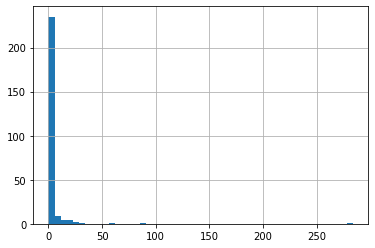

In [21]:
od_vol_filled_by_equip['vol'].hist(bins = 50);

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


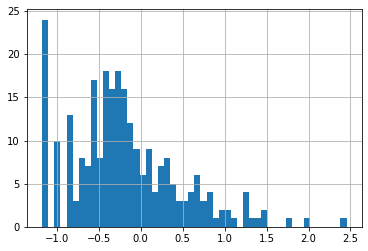

In [22]:
od_vol_filled_by_equip = tukey_rule(od_vol_filled_by_equip, 'vol')


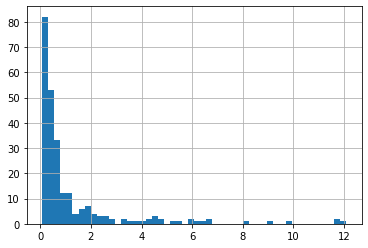

In [23]:
od_vol_filled_by_equip.loc[:,'vol'].hist(bins = 50);

In [56]:
import seaborn as sns
def best_feats(df, n):
    
    
    df = df.drop(columns = ['fid','lid'])
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df[df.vol > 0]
    X = df.drop(columns=['vol'])
    
    model = feature_selection.SelectKBest(score_func=feature_selection.f_regression,\
                                      k=n)

    model.fit(X, df['vol'])
    
    X_new = model.transform(X)
    y = pd.DataFrame(X_new)
    ax = sns.heatmap(X_new,center = 4)
    
    X.columns[model.get_support(indices=True)]

    # 1st way to get the list
    vector_names = list(X.columns[model.get_support(indices=True)])
    
    
    return vector_names

Most correlated features: ['cost_f', 'renda_familiar_media', 'renda_per_capita', ' profissional_liberal ', 'emprego_serviço_outros', ' empregos_por_vinculo_empregaticio_profissional_liberal ', 'prod_taxi_convencional', 'prod_dirigindo_moto', ' t_viagem_coletivo ', ' atr_dirigindo_moto ']


C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


247

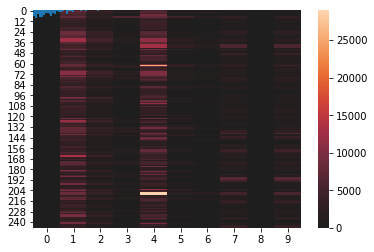

In [57]:
# sampling
#get_corr_feats
#best_feats
equip_id = 12716
n_feats = 10

od_vol_filled_by_equip = od_vol_filled[od_vol_filled.fid == equip_id]
od_vol_missing_by_equip = od_vol_missing[od_vol_missing.fid == equip_id]

od_vol_filled_by_equip = tukey_rule(od_vol_filled_by_equip, 'vol')


best_features = best_feats(od_vol_filled_by_equip, n_feats)

print('Most correlated features:',best_features)

X = od_vol_filled_by_equip[best_features]
y = od_vol_filled_by_equip[['vol']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


len(od_vol_filled_by_equip[['fid','lid','vol']])

C:\Users\alexa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Most correlated features: ['cost_f', 'renda_familiar_media', 'renda_per_capita', ' profissional_liberal ', 'emprego_serviço_outros', ' empregos_por_vinculo_empregaticio_profissional_liberal ', 'prod_taxi_convencional', 'prod_dirigindo_moto', ' t_viagem_coletivo ', ' atr_dirigindo_moto ']
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 640 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Pipeline(memory=None,
         steps=[('fit',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False)
r2_Score: 0.37187522306243526


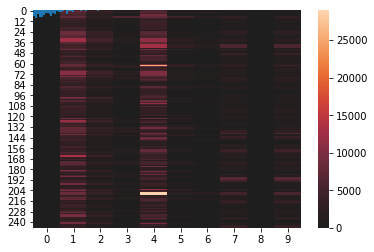

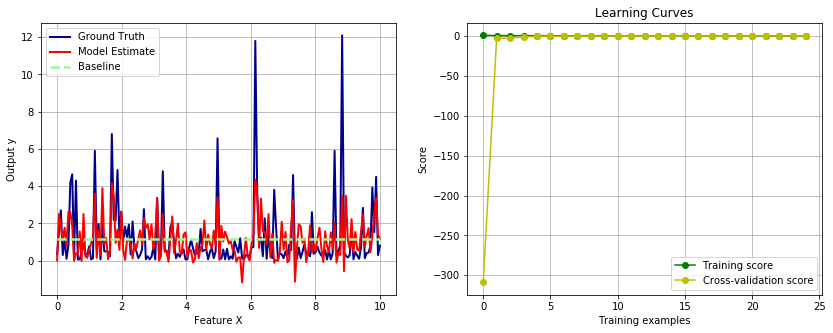


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 Lasso(alpha=0.06, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)
r2_Score: 0.3570823455813349


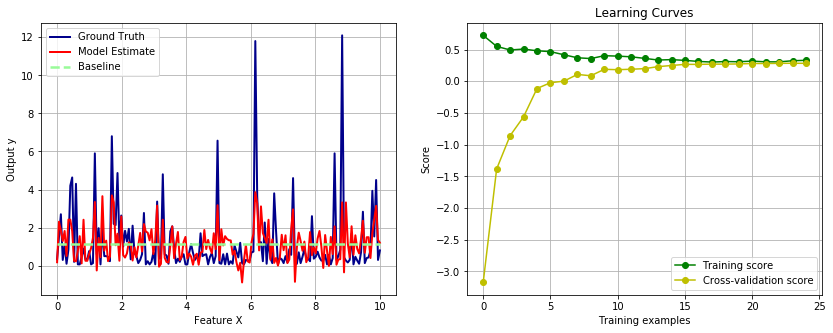


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 Ridge(alpha=200, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
r2_Score: 0.24645479089840383


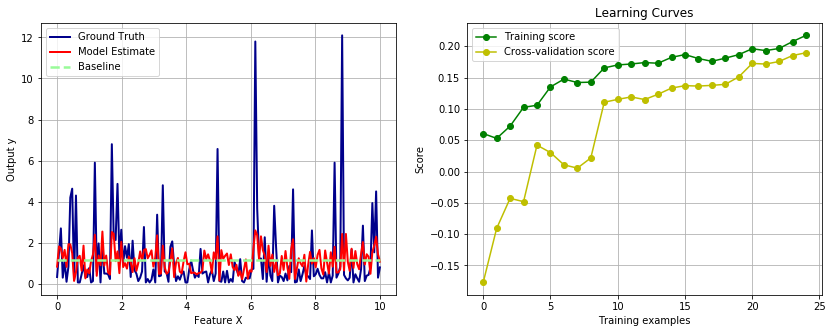


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 SGDRegressor(alpha=0.1, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='adaptive',
                              loss='squared_loss', max_iter=1000,
                              n_iter_no_change=5, penalty='l1', power_t=0.25,
                              random_state=None, shuffle=True, tol=0.001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)
r2_Score: 0.34814625478440964


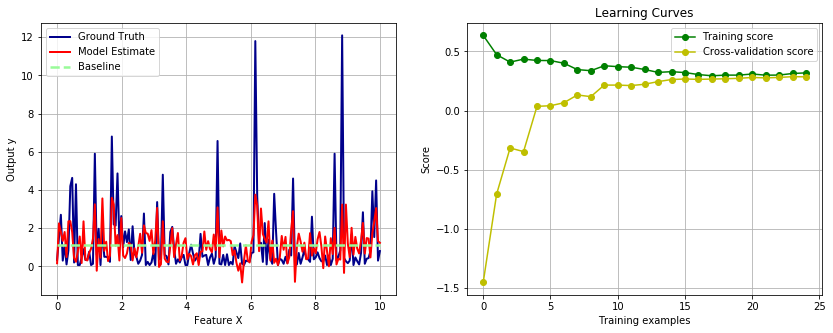


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 LassoLars(alpha=0.005, copy_X=True, eps=2.220446049250313e-16,
                           fit_intercept=True, fit_path=True, max_iter=500,
                           normalize=True, positive=False, precompute='auto',
                           verbose=False))],
         verbose=False)
r2_Score: 0.3556843561903187


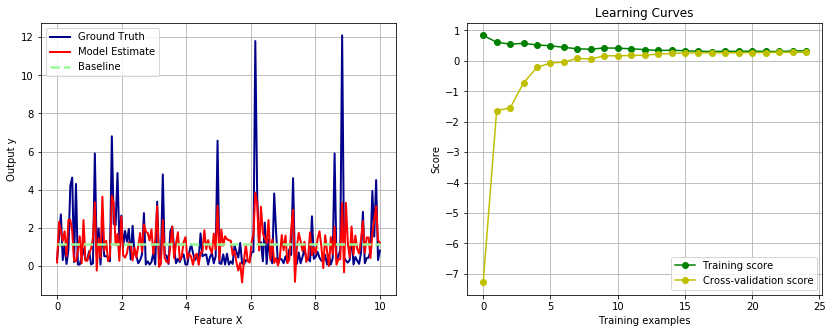


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 BayesianRidge(alpha_1=550, alpha_2=650, compute_score=False,
                               copy_X=True, fit_intercept=True, lambda_1=1e-06,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               tol=0.001, verbose=False))],
         verbose=False)
r2_Score: 0.36499658475467756


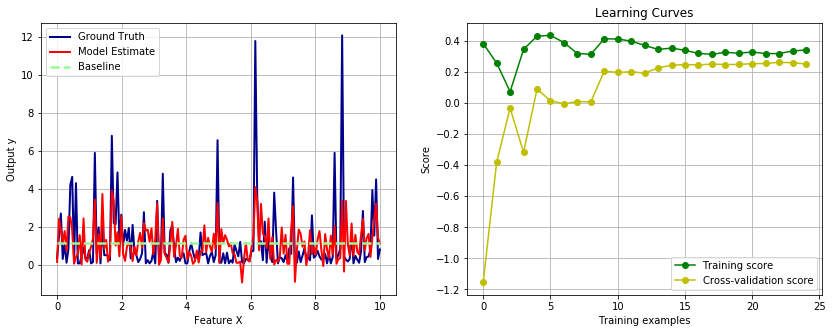


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 ARDRegression(alpha_1=1e-07, alpha_2=1e-06,
                               compute_score=False, copy_X=True,
                               fit_intercept=True, lambda_1=1e-07,
                               lambda_2=1e-06, n_iter=300, normalize=False,
                               threshold_lambda=10000.0, tol=0.001,
                               verbose=False))],
         verbose=False)
r2_Score: 0.36597075773243914


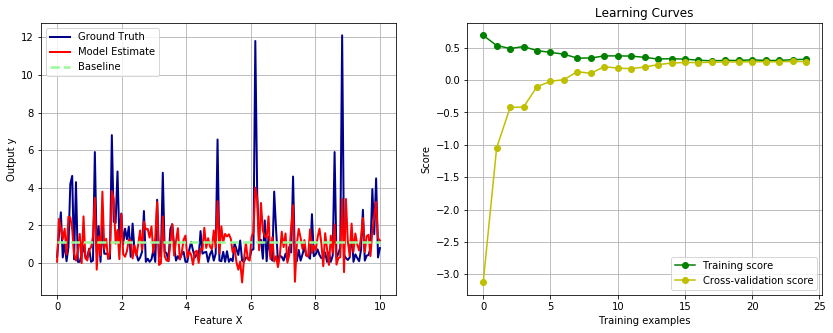


____________________________________________________________________________________

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('fit',
                 PassiveAggressiveRegressor(C=1.0, average=False,
                                            early_stopping=False, epsilon=0.1,
                                            fit_intercept=True,
                                            loss='epsilon_insensitive',
                                            max_iter=500, n_iter_no_change=5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False))],
         verbose=False)
r2_Score: -0.0012137425505482913


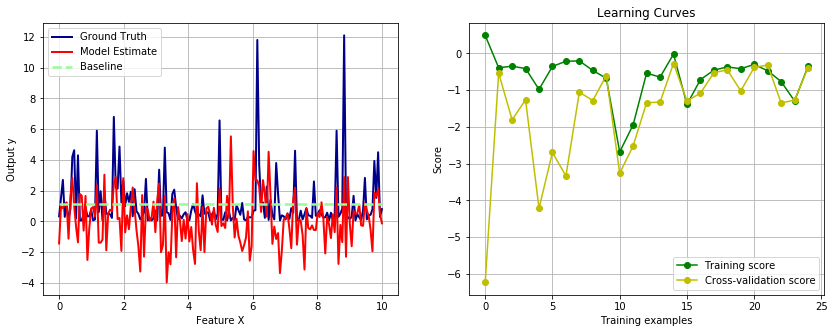


____________________________________________________________________________________

Model with the best metric 

Pipeline(memory=None,
         steps=[('fit',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False)
r2 score: 0.37187522306243526


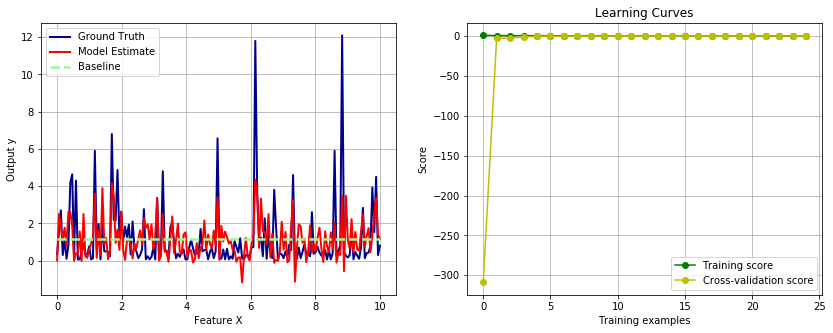

C:\Users\alexa\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,vol
20549,1.217848
20550,1.058138
20551,1.137993
20553,0.842684
20554,0.643047
20557,1.199004
20558,0.101297
20561,0.000000
20562,0.000000
20566,1.459142


In [63]:
from sklearn.pipeline import Pipeline
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


# sampling
#get_corr_feats
#best_feats

# equips_number = []
# equips_score = []
# equip_score = {}
    
equip_id = 12716




n_feats = 10
# equips_number.append(number)
od_vol_filled_by_equip = od_vol_filled[od_vol_filled.fid == equip_id]
od_vol_missing_by_equip = od_vol_missing[od_vol_missing.fid == equip_id]

od_vol_filled_by_equip = tukey_rule(od_vol_filled_by_equip, 'vol')


best_features = best_feats(od_vol_filled_by_equip, n_feats)

print('Most correlated features:',best_features)

X = od_vol_filled_by_equip[best_features]
y = od_vol_filled_by_equip[['vol']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)


od_vol_missing_by_equip[['fid','lid','vol']]


# modeling

trainingData    = X_train
trainingScores  = y_train
predictionData  = X_test


pipe1 = Pipeline([('fit', linear_model.LinearRegression())])

pipe2 = Pipeline([('standard', StandardScaler()),('fit', linear_model.Lasso())])

pipe3 = Pipeline([('standard', StandardScaler()), ('fit', linear_model.Ridge())])

pipe4 = Pipeline([('standard', StandardScaler()), ('fit' , SGDRegressor())])

pipe5 = Pipeline([('standard', StandardScaler()),('fit', linear_model.LassoLars())])

pipe6 = Pipeline([('standard', StandardScaler()), ('fit', linear_model.BayesianRidge())])

pipe7 = Pipeline([('standard', StandardScaler()), ('fit', linear_model.ARDRegression())])

pipe8 = Pipeline([('fit', XGBRegressor())])

pipe9 = Pipeline([('standard', StandardScaler()),('fit',  linear_model.PassiveAggressiveRegressor())])


# Create param grid.

sgdr_param = {'fit__alpha' : [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              #'fit__max_iter': [1000, 500,500], # number of epochs,
              'fit__learning_rate' : ['constant','optimal','invscaling','adaptive'],
              'fit__penalty': [ 'none', 'l2', 'l1', 'elasticnet'],
              'fit__loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive']
             }

lasso_params = {'fit__alpha':[0.005, 0.02, 0.025, 0.03, 0.05, 0.06]}

ridge_params = {'fit__alpha':[200, 230, 250, 265, 270, 275, 290, 300, 550, 580, 600, 620, 650]}

bayesianRidge_params = {'fit__alpha_1':[550, 580, 600, 620, 650],
                        'fit__alpha_2':[550, 580, 600, 620, 650],
                       }
ard_params = {'fit__alpha_1':[1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
#               'fit__alpha_2':[1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
              'fit__lambda_1':[1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
#               'fit__lambda_2':[1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
                       }

xgb_parameters = {'fit__nthread':[4], #when use hyperthread, xgboost may become slower
              'fit__objective':['reg:linear'],
              'fit__learning_rate': [.03, 0.05, .07], #so called `eta` value
              'fit__max_depth': [5, 6, 7],
              'fit__min_child_weight': [4],
              'fit__silent': [1],
              'fit__subsample': [0.7],
              'fit__colsample_bytree': [0.7],
              'fit__n_estimators': [500],
                 }

rf_param = {'fit__bootstrap': [True],
            'fit__max_depth': [50, 75, 100],
            'fit__max_features': ['auto'],
            'fit__min_samples_leaf': [1],
            'fit__min_samples_split': [2],
            'fit__n_estimators': [100,200,500,1000]
            }

lr_param = {'fit__normalize':[True,False]}

PAR_param = {'fit__max_iter': [100 , 500 , 1000 , 20000]}


models = {
           'LR': GridSearchCV(pipe1,
                                 param_grid=lr_param, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
           'Lasso': GridSearchCV(pipe2, 
                                 param_grid=lasso_params, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
           'Ridge': GridSearchCV(pipe3, 
                                 param_grid=ridge_params, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
           'SGDR' : GridSearchCV(pipe4, 
                                 param_grid=sgdr_param, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
           'LassoLars': GridSearchCV(pipe5, 
                                 param_grid=lasso_params, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
           'BayesianRidge': GridSearchCV(pipe6, 
                                 param_grid=bayesianRidge_params, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
           'ARDRegression': GridSearchCV(pipe7, 
                                 param_grid=ard_params, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),
            'par': GridSearchCV(pipe9,
                                 param_grid=PAR_param, cv = 5, verbose=True, n_jobs=-1, scoring = 'r2').fit(X_train, y_train),

          }



classifiers_score = {}
r2_list = []

for key, value in models.items():


    r2,best_estimator = test(value,trainingData,trainingScores,y_test,X_test)
    classifiers_score[best_estimator] = r2
    r2_list.append(r2)

    print('\n____________________________________________________________________________________\n')


print('Model with the best metric \n')

for key, value in classifiers_score.items():

    if classifiers_score[key] == max(r2_list):

        model = key
        print(model)
        print('r2 score:', max(r2_list))        
        draw_learning_curves(trainingData, trainingScores.values.ravel(), model, 25)
        
        
        
#             equip_score[number] = max(r2_list)
#             equips_score.append(max(r2_list))

missing_vol = od_vol_missing_by_equip.loc[:,best_features]

clf = model

predictionScore = clf.fit(trainingData, trainingScores.values.ravel()).predict(missing_vol)

f = lambda x : x if x > 0 else 0

od_vol_missing_by_equip.loc[:,'vol'] = np.array([f(x) for x in predictionScore])

od_vol_missing_by_equip[['vol']].head(10)
# m_df = od_vol_missing_by_equip[['fid','lid','vol']]
# m_df


In [210]:
#['LR', 'Lasso', 'Ridge', 'SGDR', 'LassoLars', 'BayesianRidge', 'ARDRegression']
#model = models['LassoLars']

missing_vol = od_vol_missing_by_equip.loc[:,corr_feats]

clf = model

predictionScore = clf.fit(trainingData, trainingScores.values.ravel()).predict(missing_vol)

f = lambda x : x if x > 0 else 0

od_vol_missing_by_equip.loc[:,'vol'] = np.array([f(x) for x in predictionScore])
m_df = od_vol_missing_by_equip[['fid','lid','vol']]
m_df

C:\Users\alexa\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,fid,lid,vol
3744,11099,13616,0.000000
4171,11099,12247,4.137171


In [306]:
final_df

,fid,lid,vol
4992,14566,10000,0.700583
5001,14566,10021,0.138788
5002,14566,12201,0.172440
5016,14566,11099,0.614418
5017,14566,11853,0.643262
5031,14566,10036,0.602056
5032,14566,11065,0.578019
5044,14566,10064,0.354254
5045,14566,10769,0.378291
5056,14566,10101,0.342388


In [307]:
od_vol_filled[['fid','lid','vol']].head()

,fid,lid,vol
0,10000,10006,6.500
1,10146,10006,4.667
2,10000,10165,4.200
3,10000,11172,5.467
4,10146,10165,4.500


In [309]:
joined_df =  pd.concat([final_df,od_vol_filled[['fid','lid','vol']]]).sort_values(by='fid', ascending=False)
od_matrix = joined_df.pivot(index='fid', columns='lid', values='vol')
od_matrix.to_excel("final_od_matrix.xlsx", engine='xlsxwriter')

In [315]:
for key, value in equip_score.items():
    if value >0.28:
        print(key,value)

10540 0.3085766531111275
10834 0.311241924820696
11044 0.3237887963640117
11706 0.2890800929750178
12529 0.2827211776344589
12716 0.354298877202474
13909 0.30771286036300083
14343 0.31157961839590664
14566 0.31157961839590664


In [1]:
equip_score

NameError: name 'equip_score' is not defined

In [31]:
x_df.head()

,radar,r2_score
0,10000,0.072184
1,10006,0.050062
2,10013,0.134770
3,10014,0.235600
4,10021,0.288918


In [32]:
x_df.to_excel("radar_scores.xlsx", engine='xlsxwriter')